In [1]:
import os
import pandas as pd
import tqdm
from tqdm import tqdm_notebook
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense
from keras.layers import Dropout, Activation, Flatten
from keras.optimizers import SGD

In [2]:
df_ge = pd.read_csv( "Sub0-RAW.csv", index_col=0)
print(df_ge.head())

           Year  Month  Day    Hours  Precipitation  Temperature  Outflow
Dates                                                                    
10/1/1980  1980     10    1  0:00:00            0.0      102.992      5.0
10/1/1980  1980     10    1  1:00:00            0.0       97.790      5.0
10/1/1980  1980     10    1  2:00:00            0.0       92.588      5.0
10/1/1980  1980     10    1  3:00:00            0.0       87.404      5.0
10/1/1980  1980     10    1  4:00:00            0.0       85.172      5.0


In [3]:
'''
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()
'''

'\nplt.figure()\nplt.plot(df_ge["Open"])\nplt.plot(df_ge["High"])\nplt.plot(df_ge["Low"])\nplt.plot(df_ge["Close"])\nplt.title(\'GE stock price history\')\nplt.ylabel(\'Price (USD)\')\nplt.xlabel(\'Days\')\nplt.legend([\'Open\',\'High\',\'Low\',\'Close\'], loc=\'upper left\')\nplt.show()\n'

In [4]:
'''
plt.figure()
plt.plot(df_ge["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()
'''

'\nplt.figure()\nplt.plot(df_ge["Volume"])\nplt.title(\'GE stock volume history\')\nplt.ylabel(\'Volume\')\nplt.xlabel(\'Days\')\nplt.show()\n'

In [5]:
print("checking if any null values are present\n", df_ge.isna().sum())

checking if any null values are present
 Year              0
Month             0
Day               0
Hours            21
Precipitation     0
Temperature       0
Outflow           0
dtype: int64


In [6]:
### In the complete code we can chnage parameters in two cells one is here with respect to data and second one in the Neural network cell where
### we chnage the parameters for the neural network like epochs and batch size 

### Coloumns required for the input data can remove coloumns if need less number of features 
#train_cols = ["Open","High","Low","Close","Volume"]
train_cols = ["Precipitation","Temperature","Outflow"]
#train_cols = ["Temperature","Outflow"]
label_cols = ["Outflow"]

#### Number of timesteps required 
TIME_STEPS = 18

df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))


Train and Test size 148435 37109


In [7]:
# Loading training data into X
x = df_train.loc[:,train_cols].values
#noise=abs((np.random.rand(x.shape[0],x.shape[1]) )*10)
#x = x + noise
y = df_train.loc[:,label_cols].values

x_train=x
y_train=y
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values
print(x_train)

[[  0.    102.992   5.   ]
 [  0.     97.79    5.   ]
 [  0.     92.588   5.   ]
 ...
 [  0.     74.354   1.   ]
 [  0.     79.142   1.   ]
 [  0.     83.948   1.   ]]


In [8]:
def build_timeseries(mat, y_label,y_label_Actual, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    y_Actual = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] =y_label[TIME_STEPS+i, 0]
        y_Actual[i] =y_label_Actual[TIME_STEPS+i, 0]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y, y_Actual

In [9]:

# Min Max scalr normalizing
# Parameters for normalizing the training data
min_max_scaler_X_Train = MinMaxScaler(feature_range = (0, 1))
min_max_scaler_Y_Train = MinMaxScaler(feature_range = (0, 1))

# Parameters for normalizing the testing data
min_max_scaler_X_Test = MinMaxScaler(feature_range = (0, 1))
min_max_scaler_Y_Test = MinMaxScaler(feature_range = (0, 1))


# Normalizing Data Training Data
x_train_Nor  = min_max_scaler_X_Train.fit_transform(x_train)
y_train_Nor  = min_max_scaler_Y_Train.fit_transform(y_train)

# Converting the data into timeseries 
X_Train, Y_Train, Y_Train_Actual = build_timeseries(x_train_Nor, y_train_Nor,y_train,TIME_STEPS)

# Normalizing Validation  Data
x_test_Nor =  min_max_scaler_X_Test.fit_transform(x_test)
y_test_Nor  = min_max_scaler_Y_Test.fit_transform(y_test)

# Converting the data into timeseries 
X_Val, Y_Val,Y_Val_Actual = build_timeseries(x_test_Nor,y_test_Nor, y_test, TIME_STEPS)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



length of time-series i/o (148417, 18, 3) (148417,)


/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



length of time-series i/o (37091, 18, 3) (37091,)


In [10]:
X_Train.shape, Y_Train.shape

((148417, 18, 3), (148417,))

In [11]:
# Initialising the RNN
model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(24, return_sequences=True,
               input_shape=(X_Train.shape[1], X_Train.shape[2])))  # returns a sequence of vectors of dimension 64
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding a Dense layer and some Dropout regularisation
model.add(Dense(20,activation='relu'))


# Adding the output layer

model.add(Dense(1, activation="linear"))




model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])
# Number of epochs and Batch Sizes can be change 
history=model.fit(X_Train, Y_Train,
           epochs=10,
          validation_data=(X_Val, Y_Val))
# Model summary for number of parameters use in the algorithm 
model.summary()

Epoch 1/10
4639/4639 [==============================] - 53s 12ms/step - loss: 1.1176e-04 - accuracy: 0.3189 - val_loss: 4.2822e-05 - val_accuracy: 0.3710
Epoch 2/10
4639/4639 [==============================] - 53s 11ms/step - loss: 3.7820e-05 - accuracy: 0.3189 - val_loss: 1.5080e-05 - val_accuracy: 0.3710
Epoch 3/10
4639/4639 [==============================] - 51s 11ms/step - loss: 2.6949e-05 - accuracy: 0.3189 - val_loss: 1.5464e-05 - val_accuracy: 0.3710
Epoch 4/10
4639/4639 [==============================] - 52s 11ms/step - loss: 2.5143e-05 - accuracy: 0.3189 - val_loss: 1.0824e-05 - val_accuracy: 0.3710
Epoch 5/10
4639/4639 [==============================] - 52s 11ms/step - loss: 2.0566e-05 - accuracy: 0.3189 - val_loss: 1.7607e-05 - val_accuracy: 0.3710
Epoch 6/10
4639/4639 [==============================] - 52s 11ms/step - loss: 1.9664e-05 - accuracy: 0.3189 - val_loss: 5.3321e-06 - val_accuracy: 0.3710
Epoch 7/10
4639/4639 [==============================] - 53s 11ms/step - loss

In [12]:
weights = model.get_weights()

In [13]:
[weights[i].shape for i in range(len(weights))]

[(3, 96),
 (24, 96),
 (96,),
 (24, 200),
 (50, 200),
 (200,),
 (50, 20),
 (20,),
 (20, 1),
 (1,)]

In [14]:
X_Train.shape

(148417, 18, 3)

In [15]:
X_Train[0], Y_Train[0]

(array([[0.        , 0.87690308, 0.00277162],
        [0.        , 0.82324545, 0.00277162],
        [0.        , 0.76958782, 0.00277162],
        [0.        , 0.71611586, 0.00277162],
        [0.        , 0.6930932 , 0.00277162],
        [0.        , 0.67007055, 0.00277162],
        [0.        , 0.6470479 , 0.00277162],
        [0.        , 0.63535091, 0.00277162],
        [0.        , 0.62346825, 0.00277162],
        [0.        , 0.61158559, 0.00277162],
        [0.        , 0.6032306 , 0.00277162],
        [0.        , 0.59468994, 0.00277162],
        [0.        , 0.58633494, 0.00277162],
        [0.        , 0.58206461, 0.00277162],
        [0.        , 0.57797995, 0.00277162],
        [0.        , 0.57370962, 0.00277162],
        [0.        , 0.63943557, 0.00277162],
        [0.        , 0.70497586, 0.00277162]]),
 0.0022172949002217295)

SyntaxError: unexpected EOF while parsing (<ipython-input-16-aaae4485d66a>, line 8)

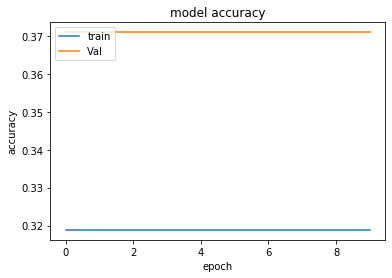

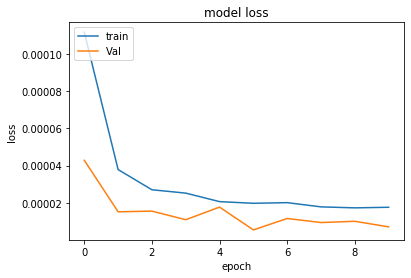

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()


In [13]:
model.save('my_model_MIN_MAX_InBuilt_Normalization.hdf5')


In [19]:
#print(model.predict(X_Val)

x_buffer = np.zeros((1,X_Train.shape[1], X_Train.shape[2]))
#model.predict(X_Val)
for i in range(100):
    x_buffer[0,:] = X_Val[i,:]
    print(min_max_scaler_Y_Train.inverse_transform(model.predict( x_buffer)),Y_Val_Actual[i])
   


[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.8537222]] 1.0
[[1.853722

In [20]:
predict =min_max_scaler_Y_Train.inverse_transform( model.predict(X_Val))

predict

array([[ 1.8537222],
       [ 1.8537222],
       [ 1.8537222],
       ...,
       [17.16408  ],
       [20.086601 ],
       [25.822714 ]], dtype=float32)

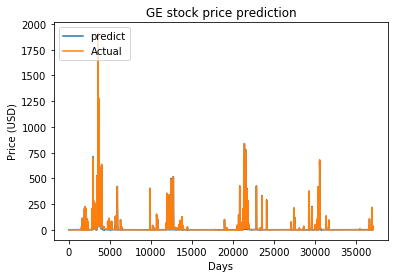

In [21]:
plt.figure()
plt.plot((predict))
plt.plot(Y_Val_Actual)

plt.title('GE stock price prediction')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['predict','Actual'], loc='upper left')

plt.savefig("figurelinearFeedforward.jpg")
plt.show()

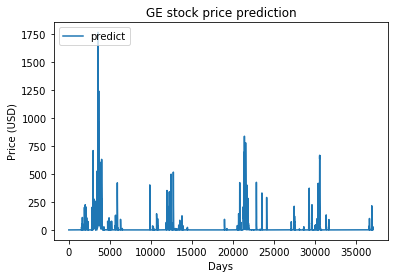

In [22]:
plt.figure()
plt.plot((predict))


plt.title('GE stock price prediction')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['predict'], loc='upper left')

#plt.savefig("figurelinearFeedforward.jpg")
plt.show()

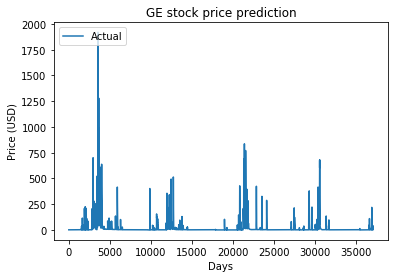

In [18]:
plt.figure()

plt.plot(Y_Val_Actual)

plt.title('GE stock price prediction')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Actual'], loc='upper left')

plt.savefig("figurelinearFeedforward.jpg")
plt.show()

In [19]:
mean_square_root = mean_squared_error(predict, Y_Val_Actual)
mean_square_root

208.19845888819628

In [20]:
square_root=np.sqrt(mean_square_root)
square_root

14.429083785472876

In [23]:
max(predict)

array([1767.9642], dtype=float32)

In [24]:
max(Y_Val_Actual)

1920.0

In [27]:
predict[3000], Y_Val_Actual[3000]

(array([129.14354], dtype=float32), 131.0)